***
### CAPSTONE PROJECT 3: FEATURE ENGINEERING/PRE-PROCESSING/MODELING ###
***
- Review the PCA's generated from the DATA CLEANING/EDA 
- Determine how many PCAs required
- Deterrmine if only most important Eigen values from PCAs would be sufficient to model.
- separate table into X and y sets.
- create Train and test data sets.
- setup ARIMA models
- setup LSTM Model
- setup VAR model.
- train models
- evaluate models.
- decide which model serves best and why.

In [229]:
# Basic Data Science Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models to test and scalar
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.metrics import mean_squared_error


***
##### FEATURE ENGINEERING
***
Determine Number of PCA's Required or if only important Eigen values from PCAs would be sufficient for our model

In [40]:
# Linux
bitcoin_df = pd.read_csv('./Data/bitcoin_df_cleaned')
most_important_features = pd.read_csv('./Data/most_important_features')

# Windows
# bitcoin_df = pd.read_csv(r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_3\Data\bitcoin_df_cleaned')
# most_important_features = pd.read_csv(r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_3\Data\most_important_features')

In [41]:
bitcoin_df.head()

,date,USD Exchange Trade Volume,Total Transaction Fees USD,Total Transaction Fees,Total Output Volume,Total Bitcoins,Transaction Excluding Popular Addresses,Number of Transactions per Block,Total Number of Transactions,Number of Transactions,...,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,2009-01-03,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569534,-0.630067,-0.083165,0.001835,0.248596,0.335601,-0.598022,0.023777,0.345126,-0.201025
1,2009-01-04,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569534,-0.630067,-0.083165,0.001835,0.248596,0.335601,-0.598022,0.023777,0.345126,-0.201025
2,2009-01-05,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569534,-0.630067,-0.083165,0.001835,0.248596,0.335601,-0.598022,0.023777,0.345126,-0.201025
3,2009-01-06,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569534,-0.630067,-0.083165,0.001835,0.248596,0.335601,-0.598022,0.023777,0.345126,-0.201025
4,2009-01-07,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569534,-0.630067,-0.083165,0.001835,0.248596,0.335601,-0.598022,0.023777,0.345126,-0.201025


In [42]:
bitcoin_df.columns

Index(['date', 'USD Exchange Trade Volume', 'Total Transaction Fees USD',
       'Total Transaction Fees', 'Total Output Volume', 'Total Bitcoins',
       'Transaction Excluding Popular Addresses',
       'Number of Transactions per Block', 'Total Number of Transactions',
       'Number of Transactions', 'Number of Unique Addresses Used',
       'My Wallet Transaction Volume', 'My Wallet Number of Users',
       'Number of Transactions per Day', 'Market Capitalization',
       'Market Price', 'Miners Revenue', 'Hash Rate',
       'Estimated Transaction Volume USD', 'Estimated Transaction Volume',
       'Difficulty', 'Cost Percent of Transaction Volume',
       'Cost per Transaction', 'API Blockchain Size', 'Average Block Size',
       'Median Transaction Confirmation Time', 'PCA1', 'PCA2', 'PCA3', 'PCA4',
       'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12'],
      dtype='object')

In [43]:
print(most_important_features['Feature Name'])

0                             Difficulty
1                  Market Capitalization
2       Estimated Transaction Volume USD
3              USD Exchange Trade Volume
4           Total Number of Transactions
5                              Hash Rate
6              My Wallet Number of Users
7                         Miners Revenue
8              My Wallet Number of Users
9                    Total Output Volume
10            Total Transaction Fees USD
11    Cost Percent of Transaction Volume
Name: Feature Name, dtype: object


Since we're dealing with Cybercurrency rather than stocks, we should resample this data taking the final value per month and also start performing percentchanges per column and autocorrelation functions as we curate a final feature set with which to model.

In [44]:
bitcoin_df['date'] = pd.to_datetime(bitcoin_df['date'])
bitcoin_df.set_index('date', inplace=True)
monthly_bitcoin_df = bitcoin_df.resample(rule='ME').last()

In [45]:
monthly_bitcoin_df.head()

,USD Exchange Trade Volume,Total Transaction Fees USD,Total Transaction Fees,Total Output Volume,Total Bitcoins,Transaction Excluding Popular Addresses,Number of Transactions per Block,Total Number of Transactions,Number of Transactions,Number of Unique Addresses Used,...,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
date,,,,,,,,,,,,,,,,,,,,,
2009-01-31,0.0,0.0,0.0,6900.0,131350.0,118.0,1.0000,2660.0,118.0,118.0,...,0.565633,-0.624664,-0.082270,0.002458,0.245686,0.332645,-0.596459,0.024101,0.338810,-0.197246
2009-02-28,0.0,0.0,0.0,5650.0,300350.0,107.0,1.0101,5894.0,100.0,107.0,...,0.560841,-0.624533,-0.080818,-0.003430,0.245534,0.330761,-0.590856,0.024245,0.331745,-0.193094
2009-03-31,0.0,0.0,0.0,7100.0,473700.0,111.0,1.0000,9564.0,107.0,107.0,...,0.555870,-0.622593,-0.083748,-0.008178,0.244914,0.328785,-0.585899,0.024475,0.324328,-0.188681
2009-04-30,0.0,0.0,0.0,6550.0,646200.0,131.0,1.0000,13031.0,123.0,123.0,...,0.550927,-0.620732,-0.084030,-0.011903,0.243679,0.325225,-0.581295,0.024595,0.316735,-0.184322
2009-05-31,0.0,0.0,0.0,3700.0,814050.0,74.0,1.0000,16407.0,74.0,97.0,...,1.504016,-3.840696,64.677784,0.338447,-3.467730,-0.868214,1.005480,-0.029261,-0.245632,0.111518


In [46]:
most_important_features_list = list(most_important_features['Feature Name'].unique())

In [47]:
def feature_correlation(df, feature_list):
    pct_change_df = pd.DataFrame()
    for feature in feature_list:
       pct_change_df[f'{feature}_RET']  = df[feature].pct_change()
       
    corr = pct_change_df.corr()
    sns.heatmap(corr)

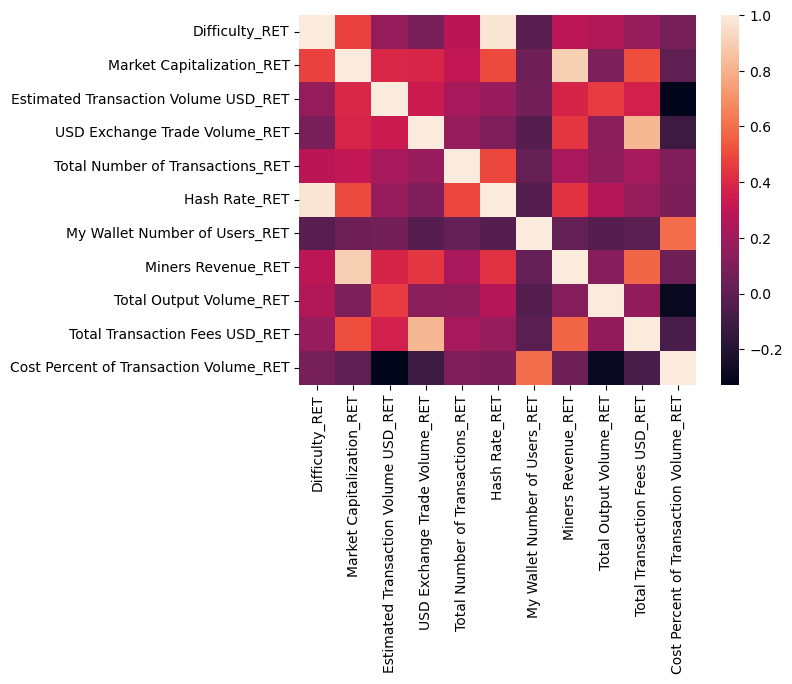

In [48]:
_ = feature_correlation(monthly_bitcoin_df, most_important_features_list)

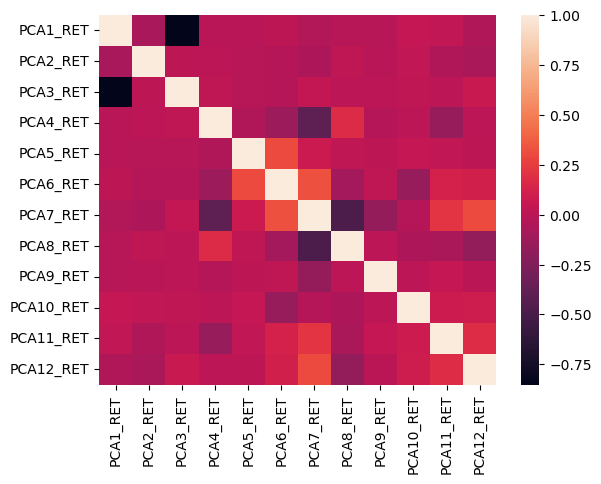

In [49]:
PCA_list = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12']
pct_change_df = feature_correlation(monthly_bitcoin_df, PCA_list)

These heatmaps pretty clearly say that for our feature set, we should use our curated PCAs rather then the primary Eigen values particularly since their degree of correlation is almost all zero which means little to no correlation between these PC vectors.  which for a multivariate time series analysis is exactly what we want.  NO CONFOUNDING VARIABLES!

In [50]:
monthly_pca_bitcoin_df = monthly_bitcoin_df[PCA_list]
monthly_pca_bitcoin_df['Market Price'] = monthly_bitcoin_df.loc[:,'Market Price']

/tmp/ipykernel_4881/203295870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_pca_bitcoin_df['Market Price'] = monthly_bitcoin_df.loc[:,'Market Price']


In [51]:
monthly_pca_bitcoin_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,Market Price
date,,,,,,,,,,,,,
2009-01-31,-4.311894,-1.941027,0.565633,-0.624664,-0.082270,0.002458,0.245686,0.332645,-0.596459,0.024101,0.338810,-0.197246,0.0
2009-02-28,-4.305432,-1.935971,0.560841,-0.624533,-0.080818,-0.003430,0.245534,0.330761,-0.590856,0.024245,0.331745,-0.193094,0.0
2009-03-31,-4.298641,-1.929858,0.555870,-0.622593,-0.083748,-0.008178,0.244914,0.328785,-0.585899,0.024475,0.324328,-0.188681,0.0
2009-04-30,-4.291903,-1.923502,0.550927,-0.620732,-0.084030,-0.011903,0.243679,0.325225,-0.581295,0.024595,0.316735,-0.184322,0.0
2009-05-31,-4.724830,-3.294112,1.504016,-3.840696,64.677784,0.338447,-3.467730,-0.868214,1.005480,-0.029261,-0.245632,0.111518,0.0


In [52]:
pct_change_df = pd.DataFrame()
for feature in PCA_list:
    pct_change_df[f'{feature}_RET']  = monthly_bitcoin_df[feature].pct_change()

In [53]:
for col in pct_change_df.columns:
    print(f'Autocorrelation for {col} is: {pct_change_df[col]}')

Autocorrelation for PCA1_RET is: date
2009-01-31         NaN
2009-02-28   -0.001499
2009-03-31   -0.001577
2009-04-30   -0.001567
2009-05-31    0.100871
                ...   
2023-12-31    0.454556
2024-01-31   -0.199415
2024-02-29    0.252745
2024-03-31   -0.158165
2024-04-30    0.118616
Freq: ME, Name: PCA1_RET, Length: 184, dtype: float64
Autocorrelation for PCA2_RET is: date
2009-01-31         NaN
2009-02-28   -0.002604
2009-03-31   -0.003158
2009-04-30   -0.003294
2009-05-31    0.712560
                ...   
2023-12-31   -0.723025
2024-01-31    3.189300
2024-02-29    0.517368
2024-03-31    0.343781
2024-04-30   -0.157031
Freq: ME, Name: PCA2_RET, Length: 184, dtype: float64
Autocorrelation for PCA3_RET is: date
2009-01-31         NaN
2009-02-28   -0.008472
2009-03-31   -0.008864
2009-04-30   -0.008892
2009-05-31    1.729972
                ...   
2023-12-31   -4.201994
2024-01-31   -1.110915
2024-02-29   -9.887594
2024-03-31   -1.083249
2024-04-30   -3.216972
Freq: ME, Name: PCA

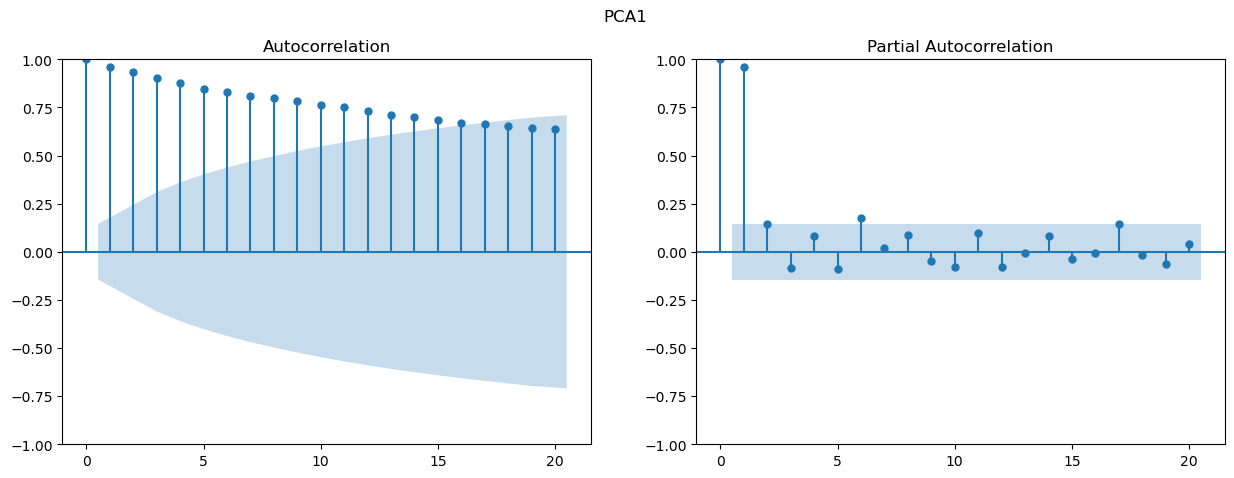

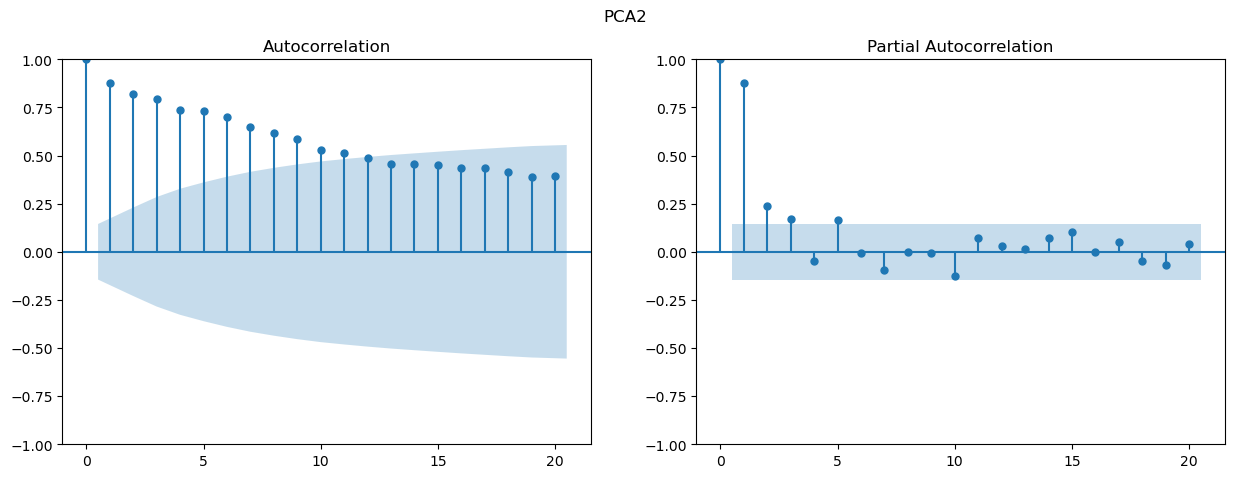

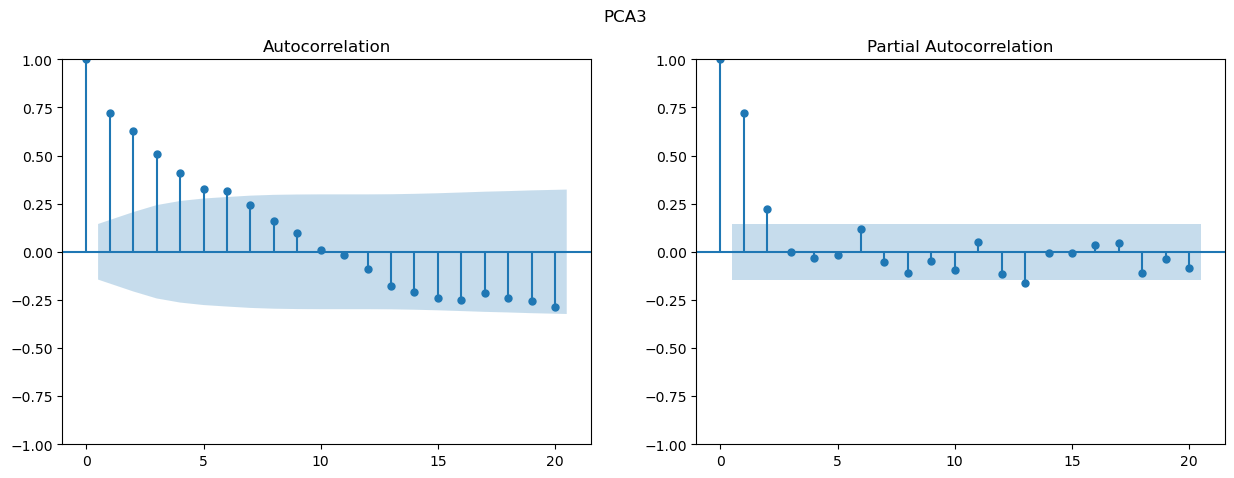

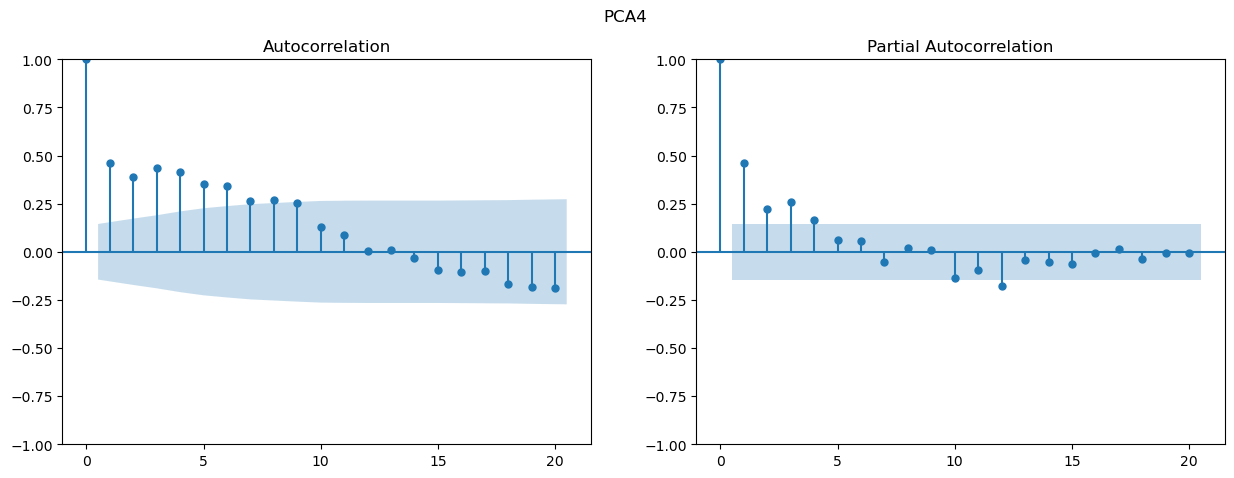

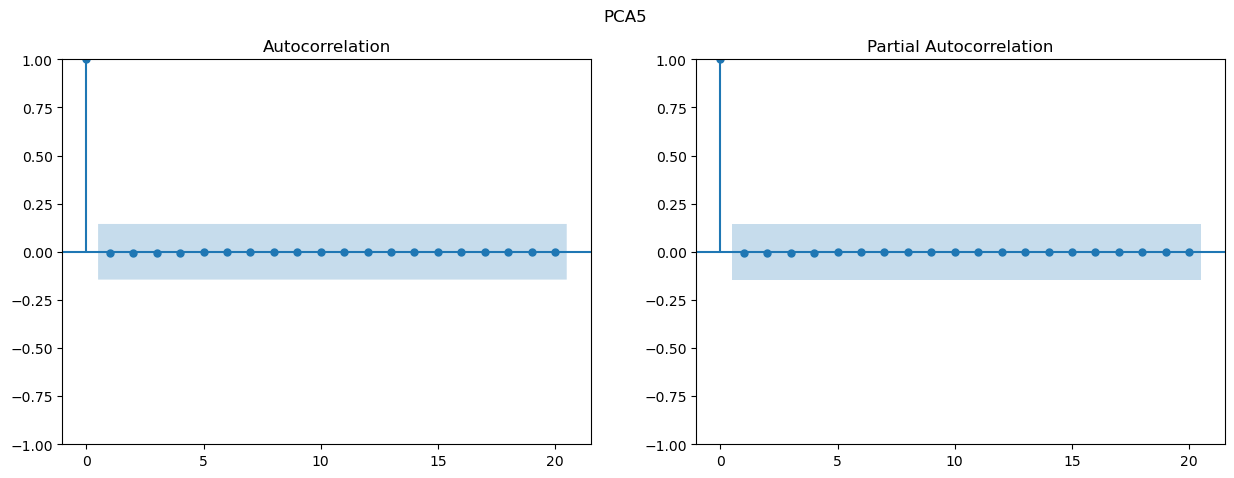

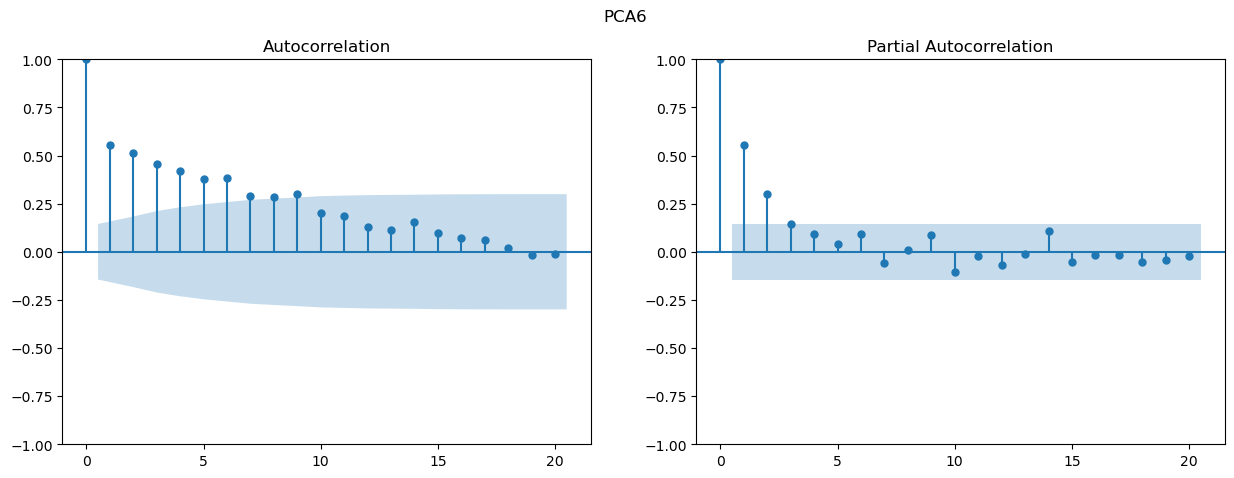

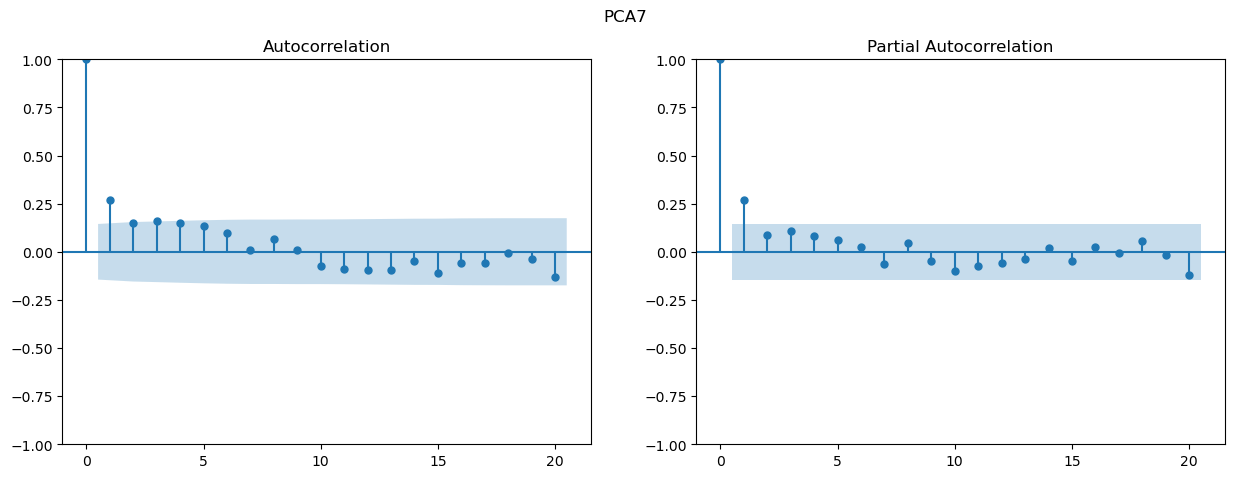

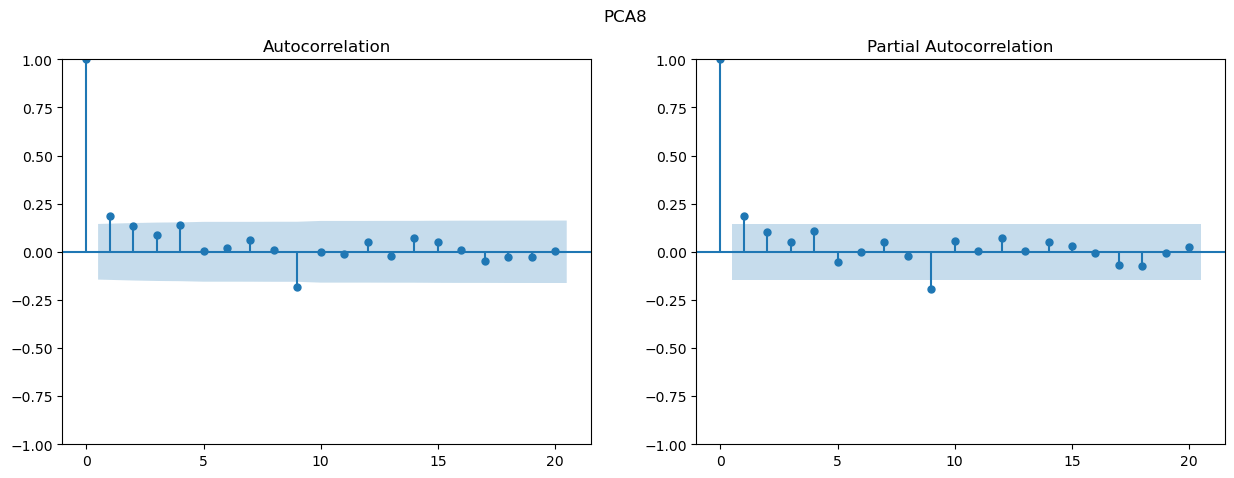

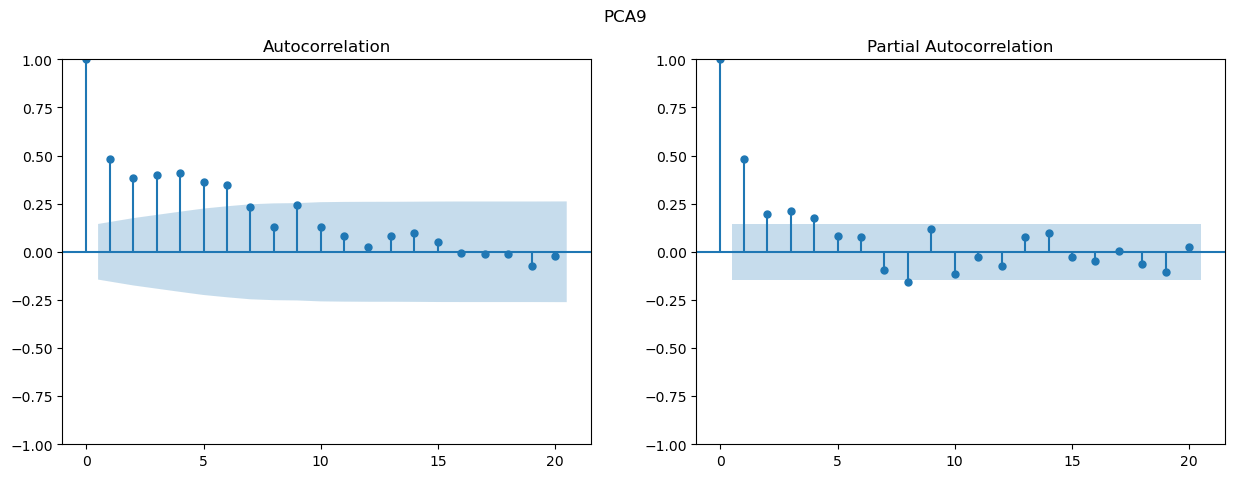

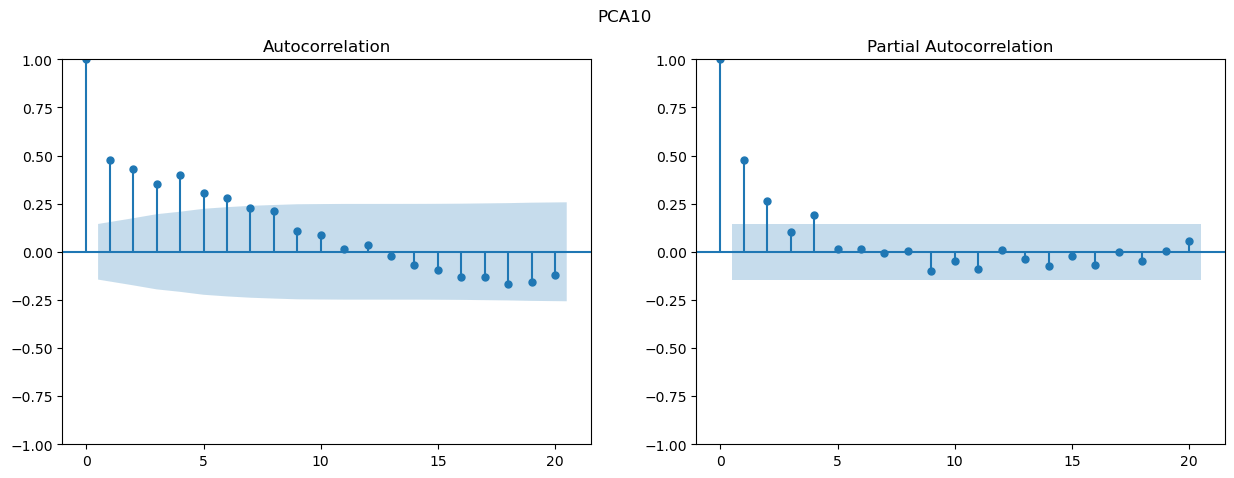

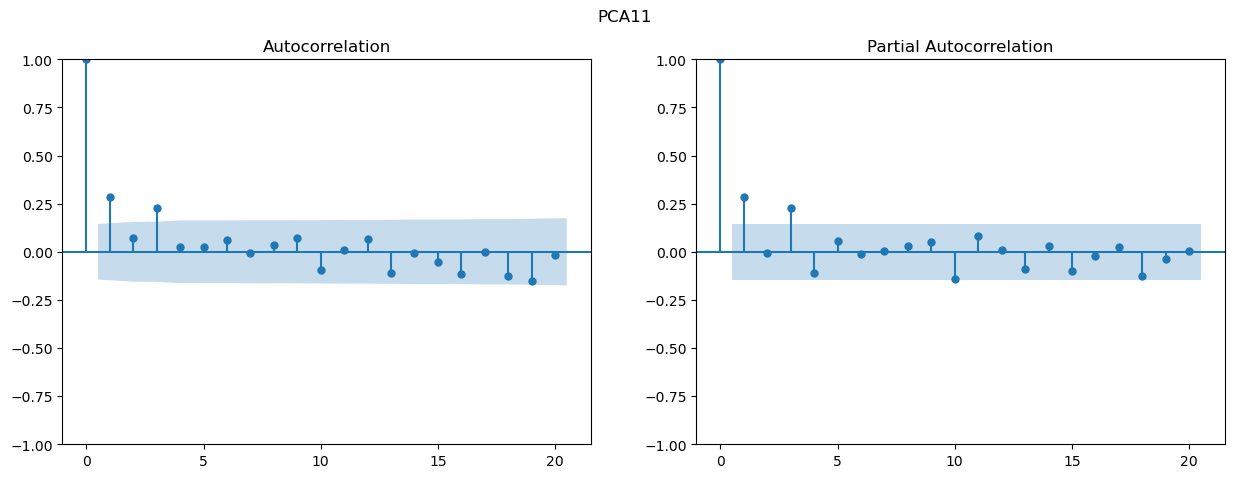

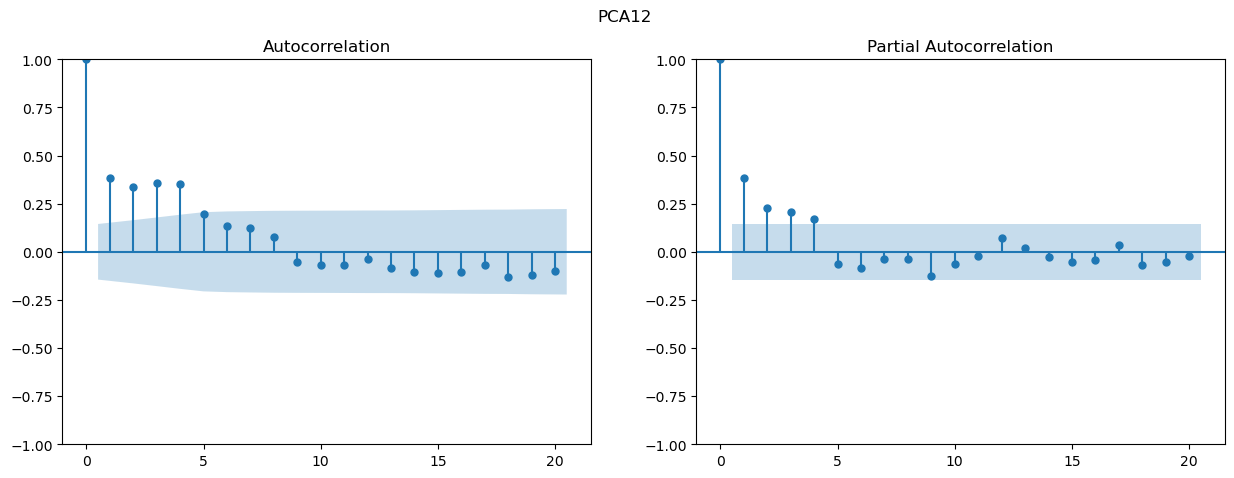

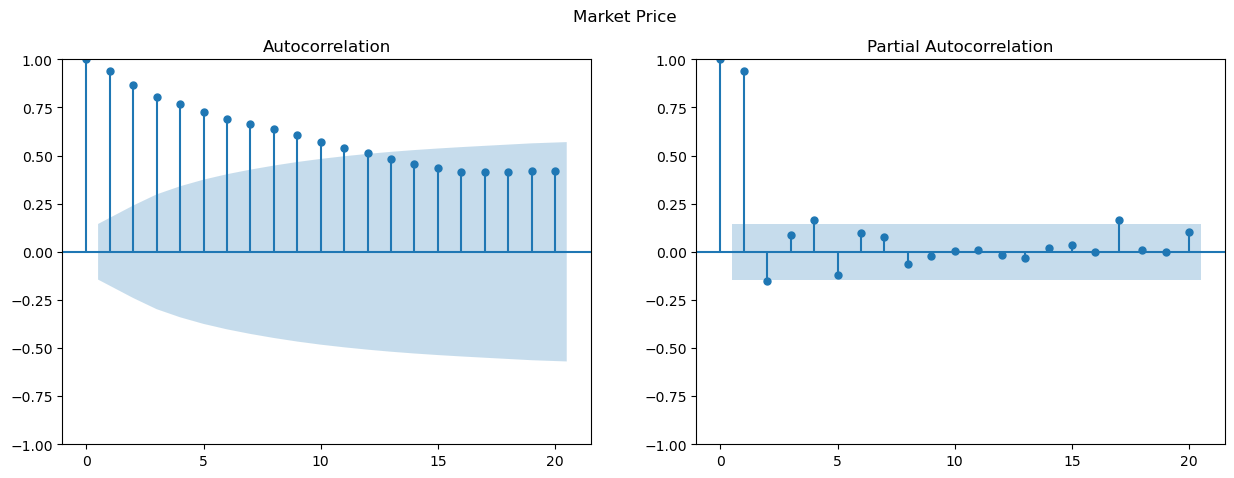

In [54]:
for col in monthly_pca_bitcoin_df.columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    plot_acf(monthly_pca_bitcoin_df[col], lags=20, alpha=0.05, ax=ax1)
    plot_pacf(monthly_pca_bitcoin_df[col], lags=20, alpha=0.05, ax=ax2)
    plt.suptitle(col)

In [55]:
for col in monthly_pca_bitcoin_df.columns:
    results = adfuller(monthly_pca_bitcoin_df[col])
    print(f'{col}: {results[1]}')

PCA1: 0.9944748550606024
PCA2: 0.651785977197969
PCA3: 0.0013995197695529913
PCA4: 0.004092780530273418
PCA5: 9.140132376771998e-05


PCA6: 0.7336435104690966
PCA7: 7.825905735425065e-07
PCA8: 2.4753876513905253e-20
PCA9: 0.039547677021059796
PCA10: 0.012464863379960828
PCA11: 1.1540659673330123e-05
PCA12: 0.0015688317695837963
Market Price: 0.9193719866523258


As per the adfuller test: PCA's _1, 2, 6_ and _Market Price_ are non-stationary whilst the rest are comfortably below our p-values indicating their usefulness for modeling.

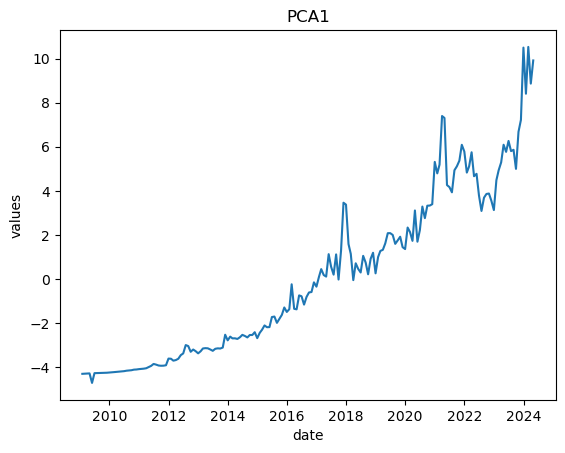

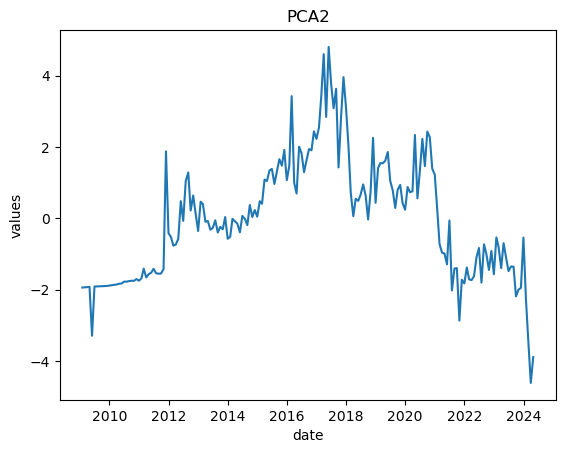

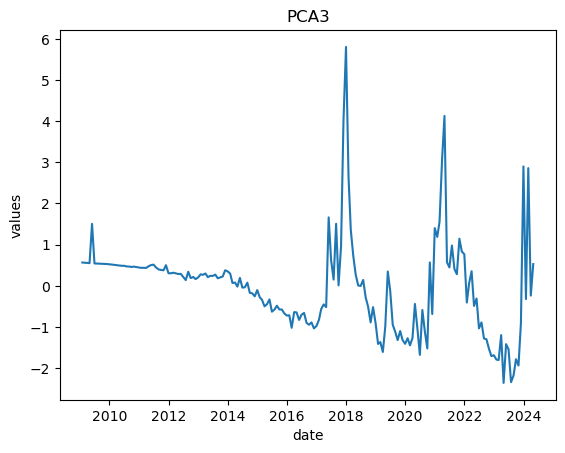

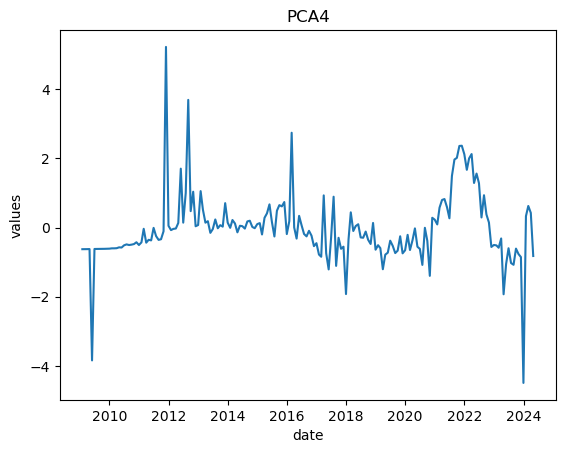

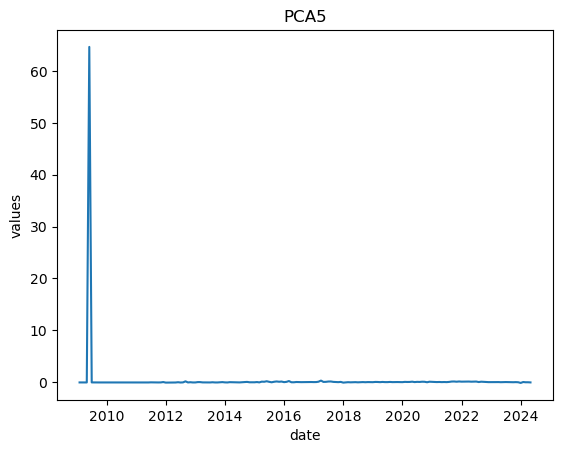

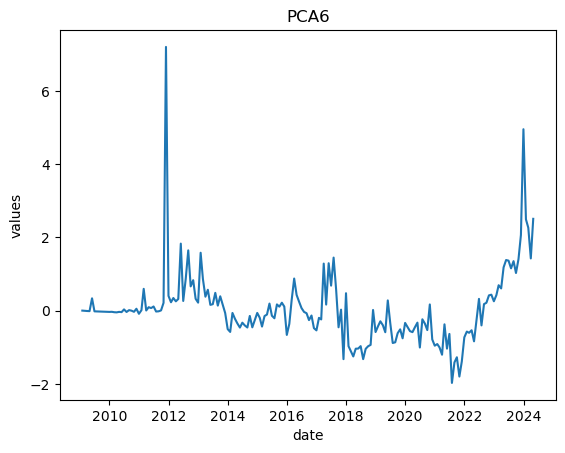

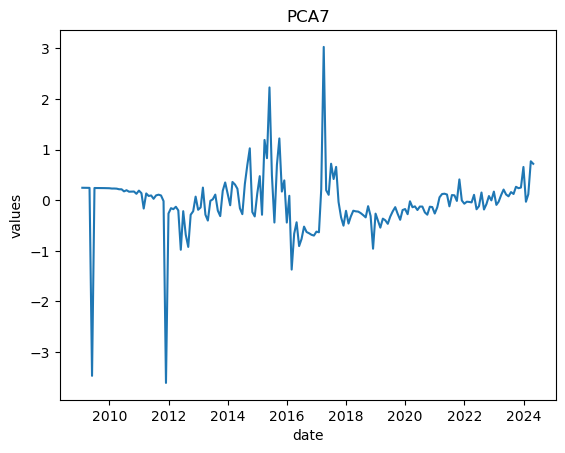

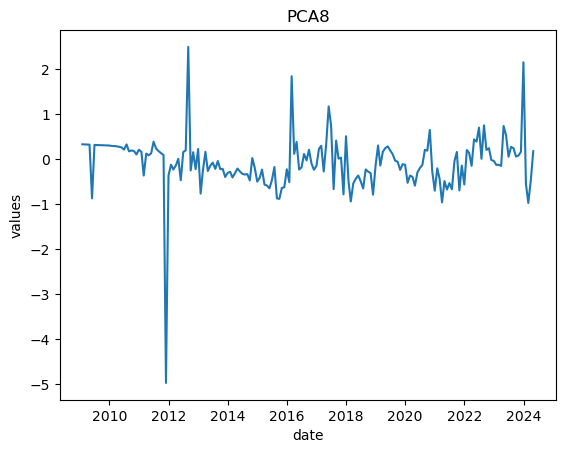

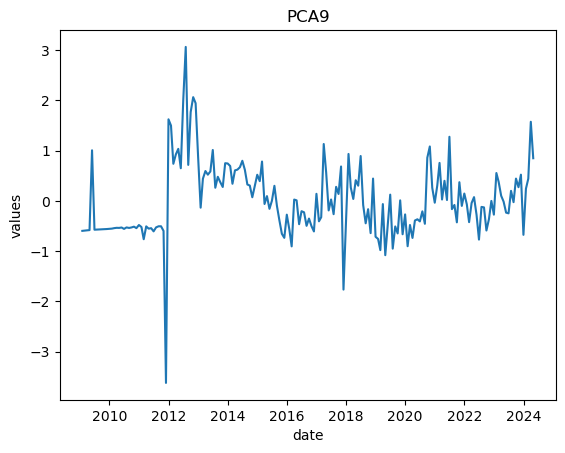

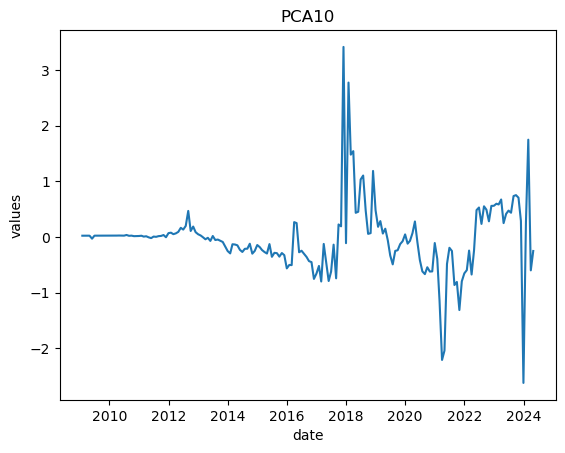

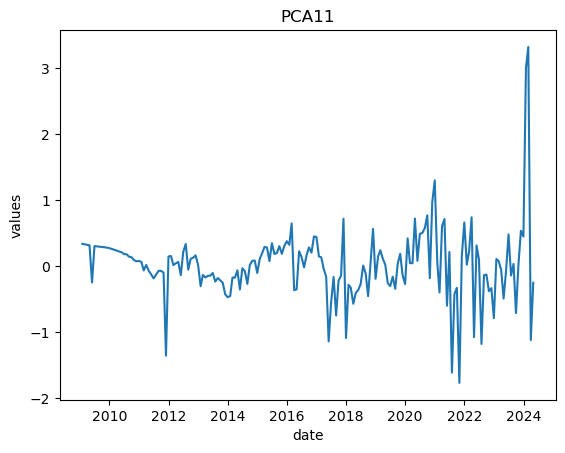

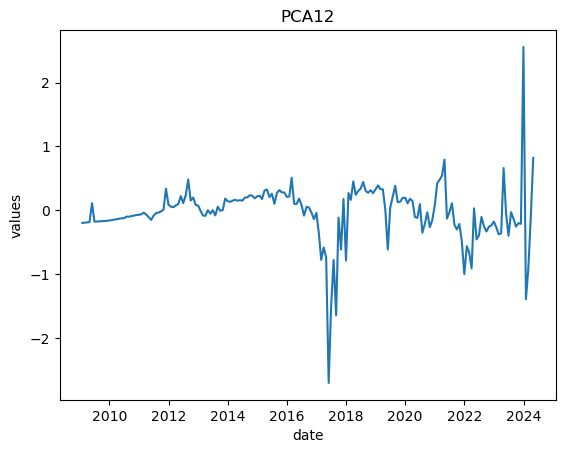

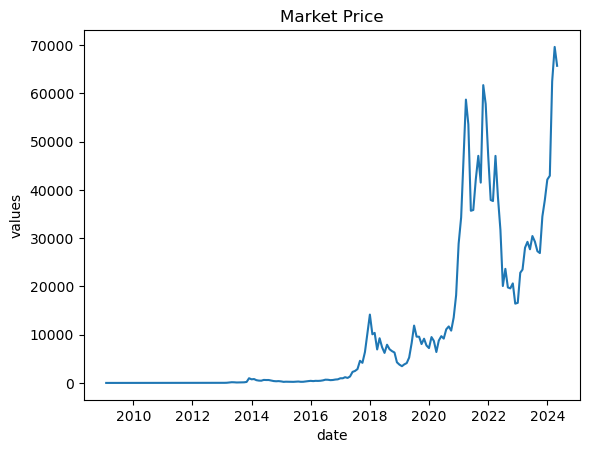

In [56]:
for feature in monthly_pca_bitcoin_df.columns:
    sns.lineplot(monthly_pca_bitcoin_df[feature])
    plt.title(feature)
    plt.xlabel('date')
    plt.ylabel('values')
    plt.show()
    plt.close()

/home/mvanslyke/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


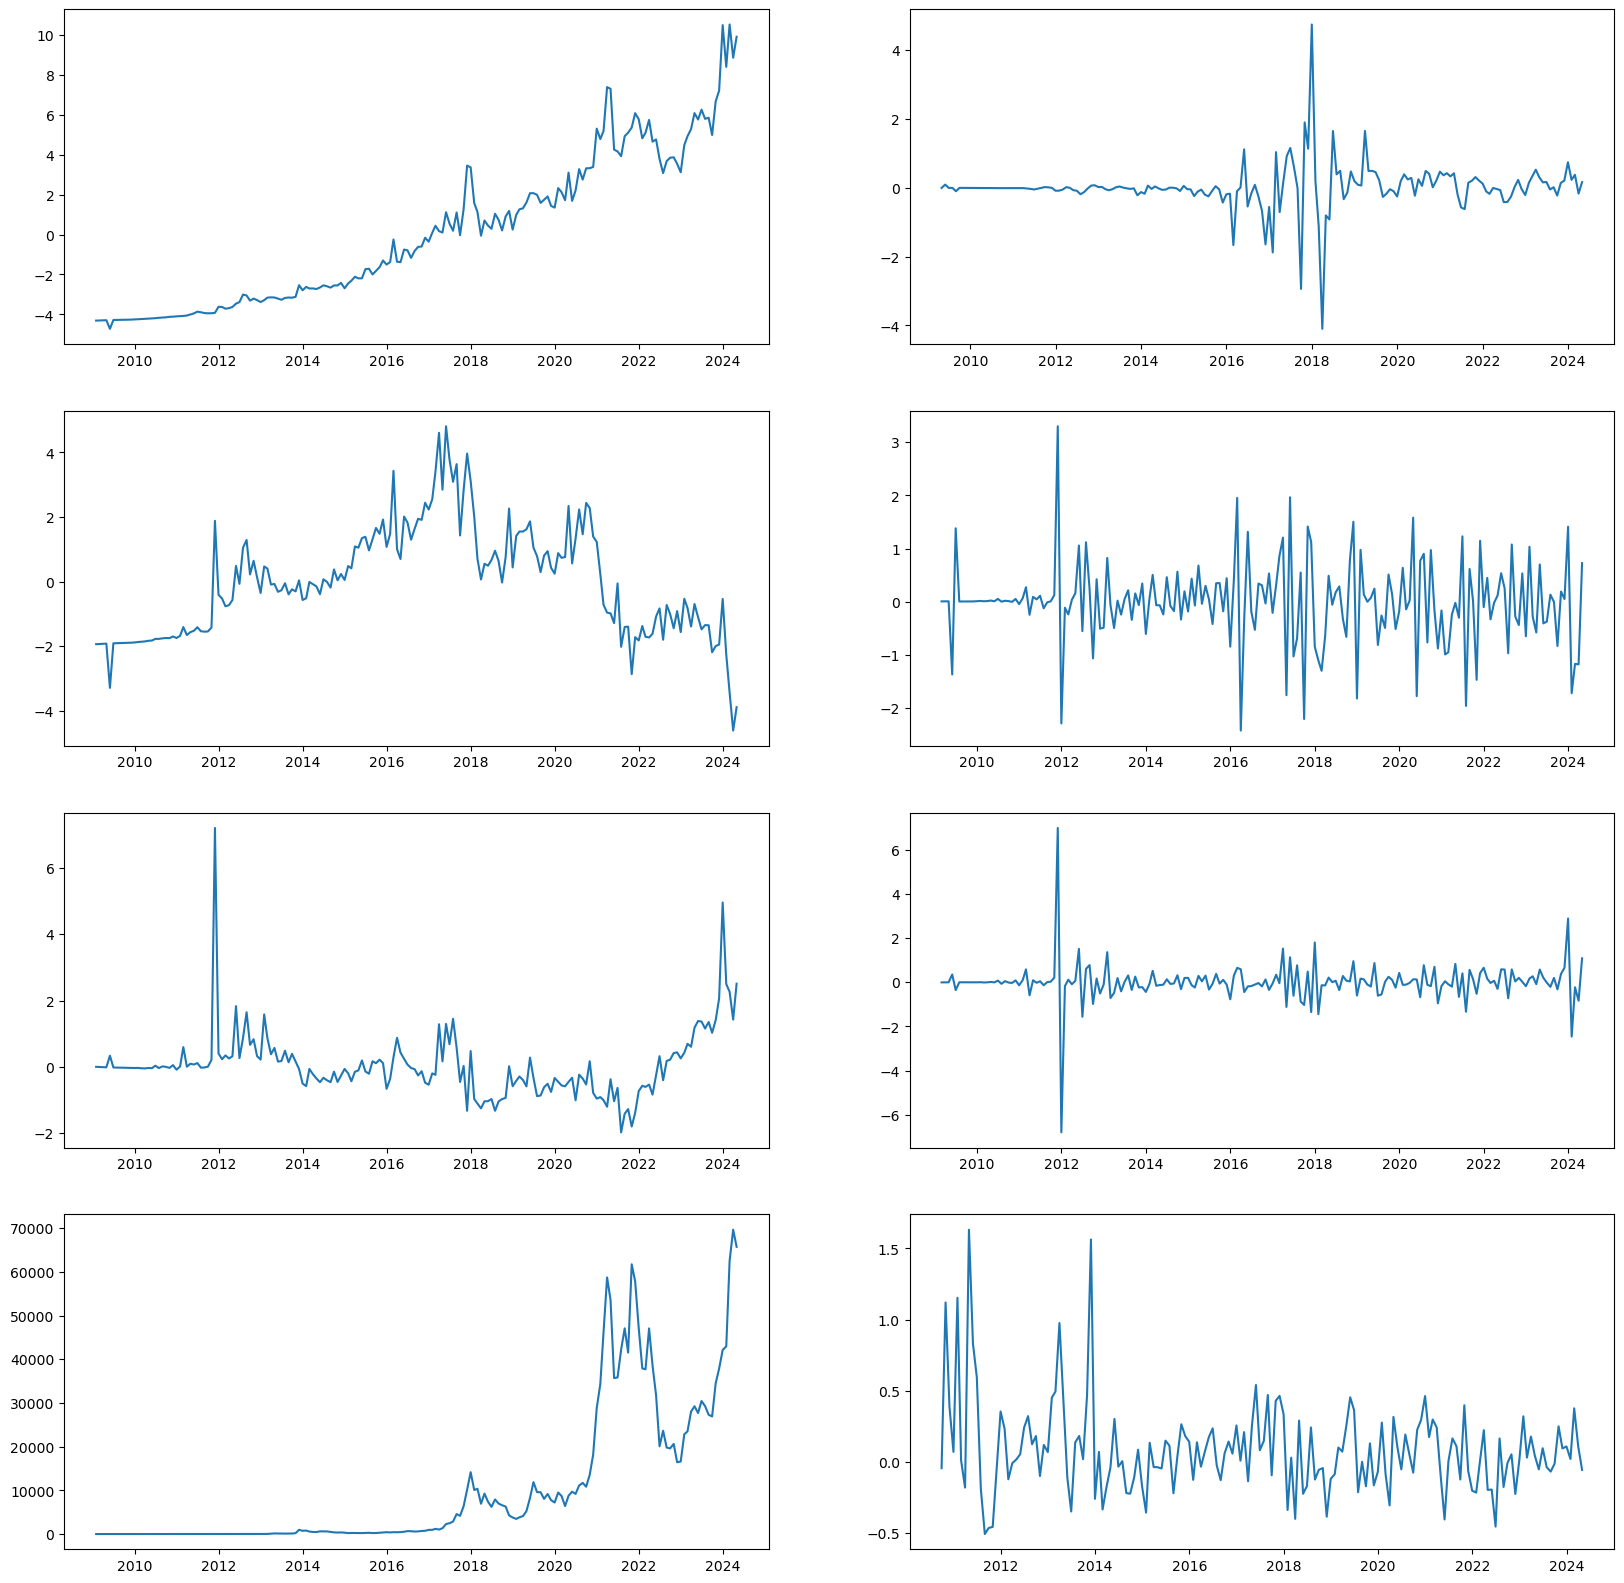

In [57]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(20,20))

ax[0][0].plot(monthly_pca_bitcoin_df['PCA1'])
ax[0][1].plot(np.log(abs(monthly_pca_bitcoin_df['PCA1'])).diff(3))

ax[1][0].plot(monthly_pca_bitcoin_df['PCA2'])
ax[1][1].plot(monthly_pca_bitcoin_df['PCA2'].diff())

ax[2][0].plot(monthly_pca_bitcoin_df['PCA6'])
ax[2][1].plot(monthly_pca_bitcoin_df['PCA6'].diff())

ax[3][0].plot(monthly_pca_bitcoin_df['Market Price'])
ax[3][1].plot(np.log(abs(monthly_pca_bitcoin_df['Market Price'])).diff())

In [58]:
np.log(abs(monthly_pca_bitcoin_df['PCA1'])).diff()

date
2009-01-31         NaN
2009-02-28   -0.001500
2009-03-31   -0.001579
2009-04-30   -0.001569
2009-05-31    0.096101
                ...   
2023-12-31    0.374701
2024-01-31   -0.222413
2024-02-29    0.225337
2024-03-31   -0.172171
2024-04-30    0.112092
Freq: ME, Name: PCA1, Length: 184, dtype: float64

That should take care of our Transformations necessary for our Models so let's save these transforms into our *monthly_pca_bitcoin_df* and proceed to our preprocessing phase.

In [59]:
for pc in ['PCA1', 'PCA2', 'PCA6', 'Market Price']:
    if pc == 'PCA1':
        monthly_pca_bitcoin_df[f'{pc}_stationary'] = np.log(abs(monthly_pca_bitcoin_df['PCA1'])).diff(3)
    elif pc == 'Market Price':
       monthly_pca_bitcoin_df[f'{pc}_stationary'] = np.log(abs(monthly_pca_bitcoin_df['Market Price'])).diff()
    else:
        monthly_pca_bitcoin_df[f'{pc}_stationary'] = monthly_pca_bitcoin_df[pc].diff()

/tmp/ipykernel_4881/37240690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_pca_bitcoin_df[f'{pc}_stationary'] = np.log(abs(monthly_pca_bitcoin_df['PCA1'])).diff(3)
/tmp/ipykernel_4881/37240690.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_pca_bitcoin_df[f'{pc}_stationary'] = monthly_pca_bitcoin_df[pc].diff()
/tmp/ipykernel_4881/37240690.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [60]:
monthly_pca_bitcoin_df.dropna(inplace=True)

/tmp/ipykernel_4881/1539485645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_pca_bitcoin_df.dropna(inplace=True)


In [61]:
monthly_pca_bitcoin_df.drop(index='2010-08-31', inplace=True)

/tmp/ipykernel_4881/96756979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_pca_bitcoin_df.drop(index='2010-08-31', inplace=True)


In [62]:
for col in monthly_pca_bitcoin_df.columns:
    if col == 'PCA1' or col == 'PCA2' or col == 'PCA6' or col == 'Market Price':
        continue
    else:
        results = adfuller(monthly_pca_bitcoin_df[col])
        print(f'{col}: {results[1]}')

PCA3: 0.002488757128967057
PCA4: 0.0031903743858386685
PCA5: 0.052408969264780565
PCA7: 0.0009089811213774929
PCA8: 3.3716112433151263e-05
PCA9: 0.025955209065977983
PCA10: 0.022185681586967387
PCA11: 3.045610733674053e-05
PCA12: 0.0033321345950459314
PCA1_stationary: 6.273045700179846e-07
PCA2_stationary: 9.797937885315451e-25
PCA6_stationary: 1.209875369834199e-15
Market Price_stationary: 2.446506687284011e-06


All of our features are now sufficiently stationary for the Analysis.

***
##### Pre-Processing
***
- Separate into _X_ and _y_ and create _train_, _test_ and/or _validate_ data sets


In [63]:
X_prime = monthly_pca_bitcoin_df[['PCA1_stationary', 'PCA2_stationary', 'PCA3', 'PCA4', 'PCA5', 'PCA6_stationary', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12', 'Market Price_stationary']].rename(columns={'PCA1_stationary': 'PCA1',
                                                                                                                                                                                                                'PCA2_stationary': 'PCA2',
                                                                                                                                                                                                                'PCA6_stationary': 'PCA6',
                                                                                                                                                                                                                'Market Price_stationary': 'Market Price'})

In [64]:
X_prime.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,Market Price
date,,,,,,,,,,,,,
2010-09-30,-0.010319,0.010471,0.457342,-0.493387,-0.087789,-0.014372,0.169396,0.196478,-0.528685,0.025425,0.136106,-0.089705,-0.045713
2010-10-31,-0.011720,-0.004247,0.466204,-0.476186,-0.088233,-0.031368,0.171458,0.183535,-0.512908,0.015964,0.093078,-0.083149,1.119890
2010-11-30,-0.010678,0.051437,0.454114,-0.423881,-0.088609,0.083576,0.126553,0.108282,-0.542487,0.017146,0.074371,-0.073406,0.387766
2010-12-31,-0.011909,-0.046599,0.445535,-0.503403,-0.089173,-0.137684,0.189747,0.212922,-0.480426,0.018838,0.080851,-0.069971,0.068993
2011-01-31,-0.007835,0.065953,0.435146,-0.427536,-0.087742,0.097656,0.138537,0.162758,-0.519869,0.023465,0.063826,-0.061376,1.152680


- ##### ARIMA MODELS #####
***

In [224]:
# Univariate Model data
X_univar = X_prime['Market Price']

X_train = X_univar[:int(len(X_univar) * 0.8)]
X_test = X_univar[int(len(X_univar) * 0.8):]

In [106]:
def ARIMA_model_selector(X, pval=3, dval=3, qval=3):
    '''Takes a univarate dataset and p, d, q parameters for an ARIMA model
    and fits, measures, and visualizes the resultant data. selects the best scores
    from both the AIC and BIC metrics and takes their full diagnostic for suitability
    returns metrics_df for further diagnostics if the lowest AIC/BIC scores are not suitable'''
    # Test Models
    model_metrics = {'AIC': {}, 'BIC': {}, 'pdq': {}}
    best_models = {'AIC': None, 'BIC': None}

    for d in range(dval):
        for p in range(pval):
            for q in range(qval):
                try:
                    model = ARIMA(X, order=(p,d,q))
                    results = model.fit()

                    model_metrics['AIC'][f'ARIMA({p},{d},{q})'] = results.aic
                    model_metrics['BIC'][f'ARIMA({p},{d},{q})'] = results.bic
                    model_metrics['pdq'][f'ARIMA({p},{d},{q})'] = (p,d,q)

                    if best_models['AIC'] == None and best_models['BIC'] == None:
                        best_models['AIC'] = [model, results]
                        best_models['BIC'] = [model, results]

                    elif best_models['AIC'][1].aic > results.aic and best_models['BIC'][1].bic > results.bic:
                        best_models['AIC'] = [model, results]
                        best_models['BIC'] = [model, results]
                        print('\nUpdated ARIMA aic and bic selection:')
                        print(f'order: ({p}, {d}, {q}) aic-score: {results.aic} bic-score:{results.bic}')

                    elif best_models['AIC'][1].aic > results.aic and best_models['BIC'][1].bic < results.bic:
                        best_models['AIC'] = [model, results]
                        print('\nUpdated ARIMA aic selection:')
                        print(f'order: ({p}, {d}, {q}) score: {results.aic}')

                    elif best_models['BIC'][1].bic > results.bic and best_models['AIC'][1].aic < results.aic:
                        best_models['BIC'] = [model, results]
                        print('\nUpdated ARIMA bic selection:')
                        print(f'order: ({p}, {d}, {q}) score: {results.bic}')

                    else:
                        print(p, d, q, results.aic, results.bic)

                except:
                    print(p, d, q, None, None)
    # Visualize AIC vs BIC scores            
    metrics_df = pd.DataFrame(model_metrics)

    plt.plot(metrics_df['AIC'], label='AIC')
    plt.plot(metrics_df['BIC'], label='BIC')
    plt.legend()
    plt.title('Model Fit Metrics')
    plt.xlabel('Models')
    plt.xticks(rotation=90)
    plt.ylabel('Scores')
    plt.show()

    # Select lowest scores from AIC and BIC and then pull their Summary and visualize their full metrics.
    # aicbic_best = [metrics_df.AIC.min(), metrics_df.BIC.min()]
    # for score in aicbic_best:
    #     for col in metrics_df.drop(columns='pdq').columns:
    #         model = ARIMA(X, metrics_df[metrics_df[col] == score]['pdq'])
    #         results = model.fit()

    for key in best_models:
        best_models[key][1].plot_diagnostics()
        print(best_models[key][1].summary())
    
    return metrics_df, best_models


Updated ARIMA aic and bic selection:
order: (0, 0, 1) aic-score: 88.18062081303954 bic-score:96.80621278264299
0 0 2 90.16555529836688 101.66634459117148
1 0 0 88.38264034360985 97.0082323132133


/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1 0 1 90.13357939664503 101.63436868944964
1 0 2 92.0374585999521 106.41344521595786
2 0 0 90.34030288633875 101.84109217914335


/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2 0 1 91.8648544252444 106.24084104125015


/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Updated ARIMA aic selection:
order: (2, 0, 2) score: 81.27059453712202
0 1 0 146.90234457391819 149.76987902437378
0 1 1 97.35022910404547 103.08529800495663
0 1 2 92.63898360536534 101.24158695673208
1 1 0 129.27418169917837 135.00925060008956
1 1 1 92.85790281020098 101.46050616156774
1 1 2 94.55394214109148 106.02407994291381
2 1 0 115.85993328026659 124.46253663163333
2 1 1 94.8132571087698 106.28339491059214
2 1 2 96.32346427782547 110.66113653010338
0 2 0 273.4308938786711 276.29070628303276


/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0 2 1 153.6507456599495 159.37037046867286


/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0 2 2 108.90174588365198 117.481183096737
1 2 0 224.38380220812462 230.10342701684797
1 2 1 136.8181319405786 145.39756915366362
1 2 2 103.866882150706 115.3061317681527
2 2 0 180.8893905403861 189.46882775347112
2 2 1 124.07626154448963 135.5155111619363


/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 2 2 105.85697540462868 120.15603742643705


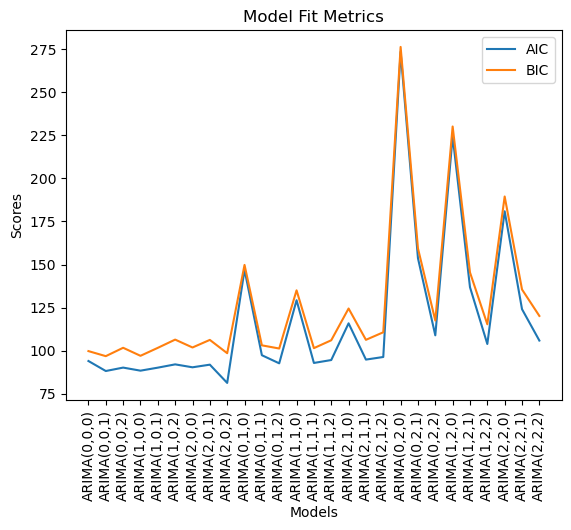

                               SARIMAX Results                                
Dep. Variable:           Market Price   No. Observations:                  131
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -34.635
Date:                Tue, 16 Apr 2024   AIC                             81.271
Time:                        10:19:16   BIC                             98.522
Sample:                    09-30-2010   HQIC                            88.281
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1007      0.045      2.219      0.026       0.012       0.190
ar.L1          0.9368      0.063     14.813      0.000       0.813       1.061
ar.L2         -0.8650      0.061    -14.227      0.0

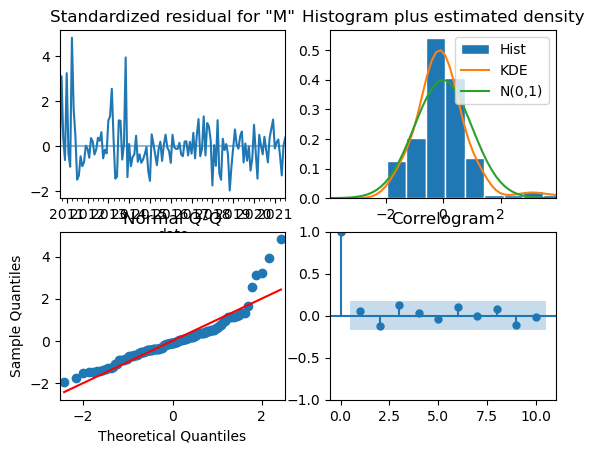

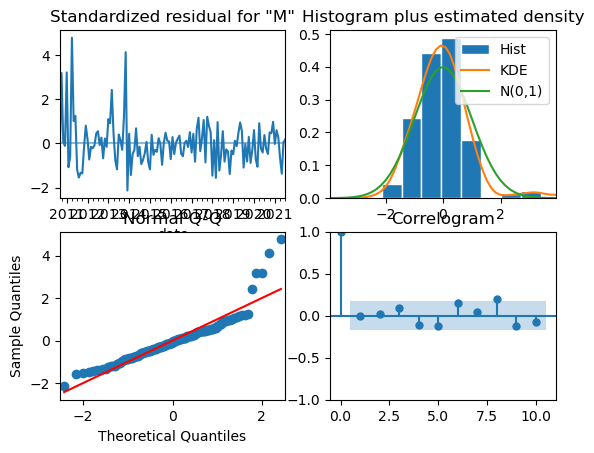

In [225]:
metrics_df, best_models = ARIMA_model_selector(X_train)

These results concur from both the AIC and BIC scores that an ARIMA(0,0,1) or MA model would work best for this univariate series. the summary in the Prob(Q) confirms that residuals are definitely uncorrelated, our theoretical quantiles are reasonabley close to the linear regression and almost all points fall within the confidence area of the correlogram.  So without very little doubt as to the this being the best univariate ARIMA (MA) Model we could do.

In [248]:
def convert_stationary_predictions_to_original_predictions(stationary_predictions, original_data):
  """Converts stationary predictions to original predictions.

  Args:
    stationary_predictions: A NumPy array of stationary predictions.
    original_data: A NumPy array of original data.

  Returns:
    A NumPy array of original predictions.
  """

  # Calculate the cumulative sum of the stationary predictions.
  cumulative_sum = np.cumsum(stationary_predictions)

  # Add the first value of the original data to the cumulative sum.
  cumulative_sum += original_data.iloc[0]

  # Calculate the original predictions by taking the exponential of the cumulative sum.
  original_predictions = np.exp(cumulative_sum)

  return original_predictions

In [226]:
ARIMA_model, ARIMA_results = best_models['AIC']

In [249]:
ARIMA_predictions = ARIMA_results.forecast(steps=len(X_test))
ARIMA_predictions_orig = convert_stationary_predictions_to_original_predictions(ARIMA_predictions, X_test)

In [250]:
rmse = np.sqrt(mean_squared_error(X_test, ARIMA_predictions))
print('RMSE:', rmse)

RMSE: 0.1968903007308791


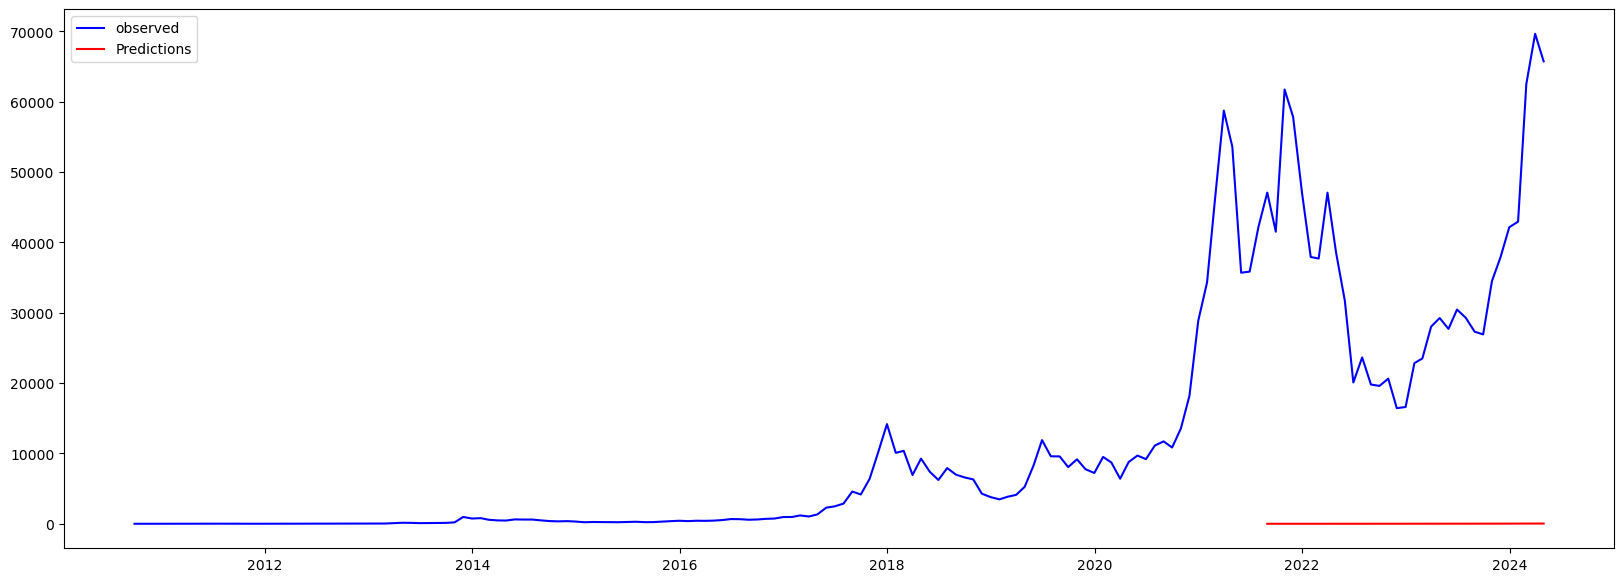

In [254]:
plt.figure(figsize=(20,7))
plt.plot(monthly_pca_bitcoin_df['Market Price'], label='observed', color='blue')
plt.plot(ARIMA_predictions_orig, label='Predictions', color='red')
plt.legend()
plt.show()